### Problem Statement 

Dataset Contains Information of Customer who filled the Application for Advanced Credit Card.It is Labelled Dataset with Approved/Not Approved as Target Variable.Our Mission is to identify customers that are Fraud.At the End we should be able to provide list of customer who cheated and got an approval.This list will be investigated further the Risk Team.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#Feature Scaling
from sklearn.preprocessing import MinMaxScaler
#Training SOM - Will use Minisom.py
from minisom import MiniSom
from pylab import bone,pcolor,colorbar,plot,show

### Data Collection 

In [3]:
#Importing Dataset - Staglog Australian Credit Approval Dataset
dataset = pd.read_csv('Credit_Card_Applications.csv')
dataset.head()

,CustomerID,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,Class
0,15776156,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,15739548,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1,0
2,15662854,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1,0
3,15687688,0,21.67,11.50,1,5,3,0.000,1,1,11,1,2,0,1,1
4,15715750,1,20.17,8.17,2,6,4,1.960,1,1,14,0,2,60,159,1


### Approach --- Self Organizing Maps 

We will be using Unsupervised Deep Learning Model - SOM . Which will do the Segmentation of customers and One of the segment will contain list of customers who cheated 

1. All the above input points will be mapped to new Output Space.Each Neuron in Output space is initialized with Vector of Weigths (15 Elements as there are 15 Features in our Dataset)

2. Now for each of customer in ROW, BMU or Winnning Node(Neuron in Output Space which is closest to that Row) is identified with Euclidean Distance.Weights will be updated for BMU and all neighborhood Neurons which falls under radius specified.In every epoch , Radius will keep on decreasing 

**Frauds are Outlying Neuron in Output Space**

3. How to detect outlier neuron in SOM ?
    - For this we need MID(Mean Interneuron Distance) , i-e For each neuron ,We are going to compute Mean of Euclidean Distance  between that Neuron and all Neurons in Neighbourhood

    - Higher MID -- Winning Node is far away from its Neighbours , Higher MID Neuron is Outlier in Output Space --- WHITE (Mostly)

4. Once we identify the Outlying Neuron in Output Space.
    - We will add markers which will help us to identify Customer associated in that Node (Got Approval/No Approval)
    - **RED CIRCLE - Customers who didnt got approval**
    - **GREEN CIRCLE - Customer who got approval**

5. At last , we are able to see MID for all Winning nodes , but besides we are going to see if customers associated to winning node are customers who got approval or didnt got approval.

6. In Outlier --  WHITE winning node , If there are both cases,Customers who got approval and who didnt got approval.We will catch those customers who were at HIGH RISK of FRAUD and got Approval

### Feature Scaling

In [14]:
# 0 - Not Approved , 1 - Approved

X = dataset.iloc[:, :-1].values 
y = dataset.iloc[:,-1].values
sc = MinMaxScaler(feature_range=(0,1))
X = sc.fit_transform(X)

Parameters for SOM
- x,y - Dimensions of Self Organizing maps We dont have that much customer 10*10
- input_len - Number of features we have in our dataset - X
- sigma - Radius of different Neighbourhood in grid.Keep Default
- learning-rate  - Decides by how much the weights are updated during each iteration
- decay_function - To improce convergence

In [15]:
som = MiniSom(x=10,y=10,input_len=15,sigma=1.0,learning_rate=0.5)
#Before Training we have to initialize weights
som.random_weights_init(X)
#Training SOM
som.train_random(data = X,num_iteration = 100)

### Visualizing Results

2D GRID ,That will contain all final winning nodes.And for each of these Winning nodes , we will get MID (Mean InterNeuron Distance) . MID of specific winning node is Mean of Distance of all neurons around that winning node inside a neighbourhood that is defined (Sigma) value i-e Radius of Neighborhood

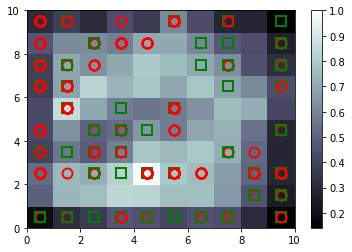

In [16]:

#Figure Window  
bone()
#Put Winning nodes on Map.We are going to add info of MID for all winning nodes that SOM identified
# distance_map will return all MID in one matrix
pcolor(som.distance_map().T)
#We would like to see if White color corresponds to High MID or LOW MID 
#Same for Dark Colors - Whether they correspond to HIGH MID or LOW MID
colorbar() 

#These values are normalized values means values are scaled from zero to one

#Highest MID is in WHITE COLOR 
#Smallest MId is in BLACK COLOR

#We will add color markers to make distinction between customers who got approval (1) and not got approved(0)
#Because customers who got cheated and got approval are more relevant targets to fraud detection than the customers who didnt got approval and cheated

#RED CIRCLE - Customers who didnt got approval
#GREEN Square - Customer who got approval

markers = ['o','s']
colors = ['r','g']

#Now we will loop through all customers and for each customer we are going to get Winning node
#and dependent on whether the customer got approval or not we are going to color this winning node
#Red Circle - If Didnt got approval Grren Square - Got Approval

#i - Different values of indexes 0-689 , x - Different vectors of customers i-e Whole row
for i,x in enumerate(X):
    #We extract the winning Node for that customer got from SOM
    w = som.winner(x)
    #For these winning node , place marker on it Based on whether he got approval or not
    #Place marker at center of square of winning node.So for that you will have to find co-ordinates
    #w[0] - x coordinate , w[1] - y coordinate - These coordinates are of lower left of winning node
    #To put it in middle we will add 0.5
    
    #If y[i] = 0 - markers[0]-circle - red - Not Approved
    #If y[i] = 1 - markers[1] - square - green - Approved
    
    #We will add color at edge .
    #But then as for inside of marker , we will not color it ,because we can have two markers for same winning node
    
    #If thats case we will see much better the two markers if theres no color inside - markerfacecolor - inside color 
    plot(w[0]+0.5,
         w[1]+0.5,
         markers[y[i]],
         markeredgecolor =  colors[y[i]],
         markerfacecolor = 'None',
         markersize=10,
         markeredgewidth = 2)
show() 

### Extract List of Customer (Who Cheated) from White (Node) -- Which is an Outlier

In [28]:
# FINDING FRAUDS

#We will use method obtained in Minisom to obtain frauds list of customers
#mappings is dictionary . We get all the Winning nodes mappings
#key - coordinates of winnning nodes . And for that Winning node we get list of customers who are there in that winning node


mappings = som.win_map(X)

#Identify frauds from that WINNING NODE (WHITE) which has High MID

#These value will keep changing based on Highest MID
frauds = mappings[(4,2)]
#Now we get whole list of cheaters

frauds = sc.inverse_transform(frauds)
customers_list = pd.DataFrame(frauds)
customers_list

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,15648069.0,0.0,24.50,1.750,1.0,8.0,4.0,0.165,0.0,0.0,0.0,0.0,2.0,132.0,1.0
1,15731586.0,0.0,29.50,2.000,1.0,10.0,8.0,2.000,0.0,0.0,0.0,0.0,2.0,256.0,18.0
2,15575605.0,0.0,24.75,13.665,2.0,11.0,8.0,1.500,0.0,0.0,0.0,0.0,2.0,280.0,2.0
3,15644453.0,0.0,18.17,10.000,1.0,11.0,8.0,0.165,0.0,0.0,0.0,0.0,2.0,340.0,1.0
4,15801473.0,0.0,20.83,0.500,1.0,10.0,2.0,1.000,0.0,0.0,0.0,0.0,2.0,260.0,1.0
5,15694666.0,0.0,26.50,2.710,1.0,8.0,4.0,0.085,0.0,0.0,0.0,0.0,1.0,80.0,1.0
6,15646594.0,0.0,15.92,2.875,2.0,11.0,4.0,0.085,0.0,0.0,0.0,0.0,2.0,120.0,1.0
7,15699238.0,0.0,22.50,8.460,1.0,14.0,4.0,2.460,0.0,0.0,0.0,0.0,2.0,164.0,1.0
8,15593959.0,0.0,21.75,1.750,1.0,5.0,3.0,0.000,0.0,0.0,0.0,0.0,2.0,160.0,1.0
9,15629750.0,0.0,24.33,2.500,1.0,3.0,5.0,4.500,0.0,0.0,0.0,0.0,2.0,200.0,457.0
